# ARIMA - Autoregressive (AR) Integrated (I) Moving Averages (MA)
We have to find values for
- p (AR term)
- d (order of differencing; for I)
- q (MA term; #MA lags)

In [3]:
import numpy as np
import pandas as pd
import math
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [4]:
# Retrieve timeseries data - daily S&P500 closing prices from 1980 to 2022
df = pd.read_csv('SPX.csv') 
df.drop(["Open", "High", "Low", "Volume"], axis=1, inplace = True)
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y') 
df.set_index('Date', inplace=True)

display(df.head())
print(df.shape)

Close
Date              
1980-05-01  105.46
1980-05-02  105.58
1980-05-05  106.38
1980-05-06  106.25
1980-05-07  107.18

(10644, 1)


## 1. Check if timeseries is stationary. Else, make it stationary
### 1. a) Visualise data & rolling statistics

In [5]:
# Get rolling mean & standard deviation
WINDOW_SIZE = math.ceil(df.shape[0]/5)
df['rolmean'] = df['Close'].rolling(window=WINDOW_SIZE).mean()
df['rolstd'] = df['Close'].rolling(window=WINDOW_SIZE).std()

In [6]:
fig = px.line(df, y=["Close", "rolmean", "rolstd"], title="Timeseries")
fig.show()

### 1. b) Dickey-Fuller test - check for stationarity

In [7]:
# H0: timeseries isn't stationary
# H1: timeseries is stationary

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(df):
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')

    dfout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
    for key, value in dftest[4].items():
        dfout['Critical value (%s)'%key] = value
    print(dfout)

dickey_fuller(df['Close'])

Result of Dickey-Fuller Test:
Test Statistic              1.297570
p-value                     0.996595
#Lags used                 39.000000
#Observations used      10604.000000
Critical value (1%)        -3.430967
Critical value (5%)        -2.861813
Critical value (10%)       -2.566915
dtype: float64


Since p-value > 0.05, we don't reject null hypothesis. The timeseries isn't stationary.

### 1. c) Differencing - to make the timeseries stationary & find d

In [8]:
# 1st differencing
df['1st diff'] = df['Close'].diff()

df['1st diff rolmean'] = df['1st diff'].rolling(window=WINDOW_SIZE).mean()
df['1st diff rolstd'] = df['1st diff'].rolling(window=WINDOW_SIZE).std()

In [9]:
fig = px.line(df, y=["1st diff", "1st diff rolmean", "1st diff rolstd"], title="Timeseries after 1st Differencing")
fig.show()

### 1. d) Perform Dickey Fuller test again after differencing

In [10]:
dickey_fuller(df['1st diff'].dropna())

Result of Dickey-Fuller Test:
Test Statistic         -1.643368e+01
p-value                 2.464831e-29
#Lags used              3.800000e+01
#Observations used      1.060400e+04
Critical value (1%)    -3.430967e+00
Critical value (5%)    -2.861813e+00
Critical value (10%)   -2.566915e+00
dtype: float64


Since p-value < 0.05, we now reject null hypothesis. The timeseries is stationary. <br>
So we stop differencing.

## 2. Plot correlations
### 2. a) Autocorrelation - to find/affirm <b>d</b> & <b>p</b>

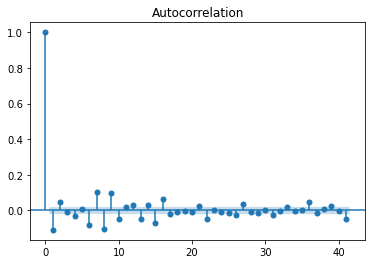

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['1st diff'].dropna());


The autocorrelation <b>falls to zero or negative very early</b> in the series. <br>
This is a sign that the series is close to being over-differenced, so we should <b>stop further differencing</b>. <br>
Hence, we fix <b>d = 1</b>. <br><br>

We can also drive <b>p</b> value from this plot, by looking at <b>where the exponential decrease ends</b>.<br>
In this plot, there is actually no exponential decrease, so we'll fix <b>p = 0</b> or (possibly) <b>p = 1</b>.

### 2. b) Partial Autocorrelation - to find <b>p</b>

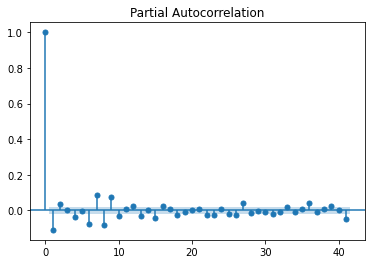

In [12]:
plot_pacf(df['1st diff'].dropna());

The plot <b>"shuts down" after lag 1</b>, as partial autocorrelation <b>close approaches the significance limit</b> (light blue region at y=0). <br>
So we'll fix <b>p = 1</b>.
## 3. The ARIMA model (based on p,d,q values)
### 3. a) Construct model

In [1]:
# p=1, d=1, q=0 or 1
#from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [13]:
model = sm.tsa.statespace.SARIMAX(df['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,365))
#model = ARIMA(df['Close'], order=(1,1,1)) #(p,d,q)

c:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [14]:
model_fit = model.fit()
print(model_fit.summary())

In the 2nd table, the values under 'coef' are the weights of p,d,q <br>
Moreover, all 'P>|z|' values are < 0.05, meaning all terms are statistically significant, which is good!

### 3. b) Make & visualise predictions

In [13]:
# START, END = indices for which you predict from start to end
START = 1000
END = len(df)

df['forecast'] = np.nan
df['forecast'][START:END] = model_fit.predict(start=START, end=END-1, dynamic=True)
fig = px.line(df, y=["Close", "forecast"], title="Forecast")
fig.show()